# 1. Import Libraries

In [2]:
#Standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time 

# library for sampling
from scipy.stats import uniform

# libraries for Data Download
import datetime
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# Keras
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


# 2. Create Classes

In [4]:
# Define a callback class
# Resets the states after each epoch (after going through a full time series)
class ModelStateReset(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        self.model.reset_states()
reset=ModelStateReset()

# Different Approach
#class modLSTM(LSTM):
#    def call(self, x, mask=None):
#        if self.stateful: 
#             self.reset_states()
#        return super(modLSTM, self).call(x, mask)


# 3. Write Functions

In [5]:
# Function to create an LSTM model, required for KerasClassifier
def create_shallow_LSTM(epochs=1, 
                        LSTM_units=1,
                        num_samples=1, 
                        look_back=1,
                        num_features=None,  
                        dropout_rate=0,
                        recurrent_dropout=0,
                        verbose=0):
    
    model=Sequential()
    
    model.add(LSTM(units=LSTM_units, 
                   batch_input_shape=(num_samples, look_back, num_features), 
                   stateful=True, 
                   recurrent_dropout=recurrent_dropout)) 
    
    model.add(Dropout(dropout_rate))
            
    model.add(Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.he_normal(seed=1)))

    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

    return model

# 4. Data

## 4.1 Import Raw Data

In [6]:
# Imports data
start_sp=datetime.datetime(1980, 1, 1) 
end_sp=datetime.datetime(2019, 2, 28)

yf.pdr_override() 
sp500=pdr.get_data_yahoo('^GSPC', 
                        start_sp,
                        end_sp)
sp500.shape

[*********************100%***********************]  1 of 1 downloaded


(9875, 6)

## 4.2 Create Features

In [7]:
# Compute the logarithmic returns using the Closing price 
sp500['Log_Ret_1d']=np.log(sp500['Close'] / sp500['Close'].shift(1))

# Compute logarithmic returns using the pandas rolling mean function
sp500['Log_Ret_1w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=5).sum()
sp500['Log_Ret_2w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=10).sum()
sp500['Log_Ret_3w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=15).sum()
sp500['Log_Ret_4w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=20).sum()
sp500['Log_Ret_8w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=40).sum()
sp500['Log_Ret_12w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=60).sum()
sp500['Log_Ret_16w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=80).sum()
sp500['Log_Ret_20w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=100).sum()
sp500['Log_Ret_24w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=120).sum()
sp500['Log_Ret_28w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=140).sum()
sp500['Log_Ret_32w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=160).sum()
sp500['Log_Ret_36w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=180).sum()
sp500['Log_Ret_40w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=200).sum()
sp500['Log_Ret_44w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=220).sum()
sp500['Log_Ret_48w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=240).sum()
sp500['Log_Ret_52w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=260).sum()
sp500['Log_Ret_56w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=280).sum()
sp500['Log_Ret_60w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=300).sum()
sp500['Log_Ret_64w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=320).sum()
sp500['Log_Ret_68w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=340).sum()
sp500['Log_Ret_72w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=360).sum()
sp500['Log_Ret_76w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=380).sum()
sp500['Log_Ret_80w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=400).sum()

# Compute Volatility using the pandas rolling standard deviation function
sp500['Vol_1w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=5).std()*np.sqrt(5)
sp500['Vol_2w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=10).std()*np.sqrt(10)
sp500['Vol_3w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=15).std()*np.sqrt(15)
sp500['Vol_4w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=20).std()*np.sqrt(20)
sp500['Vol_8w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=40).std()*np.sqrt(40)
sp500['Vol_12w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=60).std()*np.sqrt(60)
sp500['Vol_16w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=80).std()*np.sqrt(80)
sp500['Vol_20w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=100).std()*np.sqrt(100)
sp500['Vol_24w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=120).std()*np.sqrt(120)
sp500['Vol_28w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=140).std()*np.sqrt(140)
sp500['Vol_32w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=160).std()*np.sqrt(160)
sp500['Vol_36w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=180).std()*np.sqrt(180)
sp500['Vol_40w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=200).std()*np.sqrt(200)
sp500['Vol_44w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=220).std()*np.sqrt(220)
sp500['Vol_48w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=240).std()*np.sqrt(240)
sp500['Vol_52w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=260).std()*np.sqrt(260)
sp500['Vol_56w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=280).std()*np.sqrt(280)
sp500['Vol_60w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=300).std()*np.sqrt(300)
sp500['Vol_64w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=320).std()*np.sqrt(320)
sp500['Vol_68w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=340).std()*np.sqrt(340)
sp500['Vol_72w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=360).std()*np.sqrt(360)
sp500['Vol_76w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=380).std()*np.sqrt(380)
sp500['Vol_80w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=400).std()*np.sqrt(400)

# Compute Volumes using the pandas rolling mean function
sp500['Volume_1w']=pd.Series(sp500['Volume']).rolling(window=5).mean()
sp500['Volume_2w']=pd.Series(sp500['Volume']).rolling(window=10).mean()
sp500['Volume_3w']=pd.Series(sp500['Volume']).rolling(window=15).mean()
sp500['Volume_4w']=pd.Series(sp500['Volume']).rolling(window=20).mean()
sp500['Volume_8w']=pd.Series(sp500['Volume']).rolling(window=40).mean()
sp500['Volume_12w']=pd.Series(sp500['Volume']).rolling(window=60).mean()
sp500['Volume_16w']=pd.Series(sp500['Volume']).rolling(window=80).mean()
sp500['Volume_20w']=pd.Series(sp500['Volume']).rolling(window=100).mean()
sp500['Volume_24w']=pd.Series(sp500['Volume']).rolling(window=120).mean()
sp500['Volume_28w']=pd.Series(sp500['Volume']).rolling(window=140).mean()
sp500['Volume_32w']=pd.Series(sp500['Volume']).rolling(window=160).mean()
sp500['Volume_36w']=pd.Series(sp500['Volume']).rolling(window=180).mean()
sp500['Volume_40w']=pd.Series(sp500['Volume']).rolling(window=200).mean()
sp500['Volume_44w']=pd.Series(sp500['Volume']).rolling(window=220).mean()
sp500['Volume_48w']=pd.Series(sp500['Volume']).rolling(window=240).mean()
sp500['Volume_52w']=pd.Series(sp500['Volume']).rolling(window=260).mean()
sp500['Volume_56w']=pd.Series(sp500['Volume']).rolling(window=280).mean()
sp500['Volume_60w']=pd.Series(sp500['Volume']).rolling(window=300).mean()
sp500['Volume_64w']=pd.Series(sp500['Volume']).rolling(window=320).mean()
sp500['Volume_68w']=pd.Series(sp500['Volume']).rolling(window=340).mean()
sp500['Volume_72w']=pd.Series(sp500['Volume']).rolling(window=360).mean()
sp500['Volume_76w']=pd.Series(sp500['Volume']).rolling(window=380).mean()
sp500['Volume_80w']=pd.Series(sp500['Volume']).rolling(window=400).mean()

# Label data: Up (Down) if the the 1 month (≈ 21 trading days) logarithmic return increased (decreased)
sp500['Return_Label']=pd.Series(sp500['Log_Ret_1d']).shift(-21).rolling(window=21).sum()
sp500['Label']=np.where(sp500['Return_Label'] > 0, 1, 0)

# Drop NA´s
sp500=sp500.dropna("index")
sp500=sp500.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', "Return_Label"], axis=1)

## 4.3 Extract Basic Information 

In [6]:
# Show rows and columns
print("Rows, Columns:");print(sp500.shape);print("\n")

# Describe DataFrame columns
print("Columns:");print(sp500.columns);print("\n")

# Show info on DataFrame
print("Info:");print(sp500.info()); print("\n")

# Count Non-NA values
print("Non-NA:");print(sp500.count()); print("\n")

# Show head
print("Head");print(sp500.head()); print("\n")

# Show tail
print("Tail");print(sp500.tail());print("\n")

# Show summary statistics
print("Summary statistics:");print(sp500.describe());print("\n")

Rows, Columns:
(9454, 71)


Columns:
Index(['Log_Ret_1d', 'Log_Ret_1w', 'Log_Ret_2w', 'Log_Ret_3w', 'Log_Ret_4w',
       'Log_Ret_8w', 'Log_Ret_12w', 'Log_Ret_16w', 'Log_Ret_20w',
       'Log_Ret_24w', 'Log_Ret_28w', 'Log_Ret_32w', 'Log_Ret_36w',
       'Log_Ret_40w', 'Log_Ret_44w', 'Log_Ret_48w', 'Log_Ret_52w',
       'Log_Ret_56w', 'Log_Ret_60w', 'Log_Ret_64w', 'Log_Ret_68w',
       'Log_Ret_72w', 'Log_Ret_76w', 'Log_Ret_80w', 'Vol_1w', 'Vol_2w',
       'Vol_3w', 'Vol_4w', 'Vol_8w', 'Vol_12w', 'Vol_16w', 'Vol_20w',
       'Vol_24w', 'Vol_28w', 'Vol_32w', 'Vol_36w', 'Vol_40w', 'Vol_44w',
       'Vol_48w', 'Vol_52w', 'Vol_56w', 'Vol_60w', 'Vol_64w', 'Vol_68w',
       'Vol_72w', 'Vol_76w', 'Vol_80w', 'Volume_1w', 'Volume_2w', 'Volume_3w',
       'Volume_4w', 'Volume_8w', 'Volume_12w', 'Volume_16w', 'Volume_20w',
       'Volume_24w', 'Volume_28w', 'Volume_32w', 'Volume_36w', 'Volume_40w',
       'Volume_44w', 'Volume_48w', 'Volume_52w', 'Volume_56w', 'Volume_60w',
       'Volume_64w', 'V

        Log_Ret_1d   Log_Ret_1w   Log_Ret_2w   Log_Ret_3w   Log_Ret_4w  \
count  9454.000000  9454.000000  9454.000000  9454.000000  9454.000000   
mean      0.000319     0.001596     0.003191     0.004772     0.006342   
std       0.011115     0.023453     0.031869     0.038598     0.044166   
min      -0.228997    -0.319214    -0.377868    -0.365360    -0.350374   
25%      -0.004497    -0.010109    -0.012040    -0.013111    -0.015094   
50%       0.000531     0.003047     0.005691     0.008145     0.010847   
75%       0.005554     0.014624     0.020748     0.026528     0.031437   
max       0.109572     0.174887     0.195882     0.199030     0.211030   

        Log_Ret_8w  Log_Ret_12w  Log_Ret_16w  Log_Ret_20w  Log_Ret_24w  \
count  9454.000000  9454.000000  9454.000000  9454.000000  9454.000000   
mean      0.012641     0.019043     0.025468     0.031968     0.038525   
std       0.061672     0.075067     0.086494     0.097284     0.108054   
min      -0.474377    -0.532590    -0

## 4.4 Plot Data

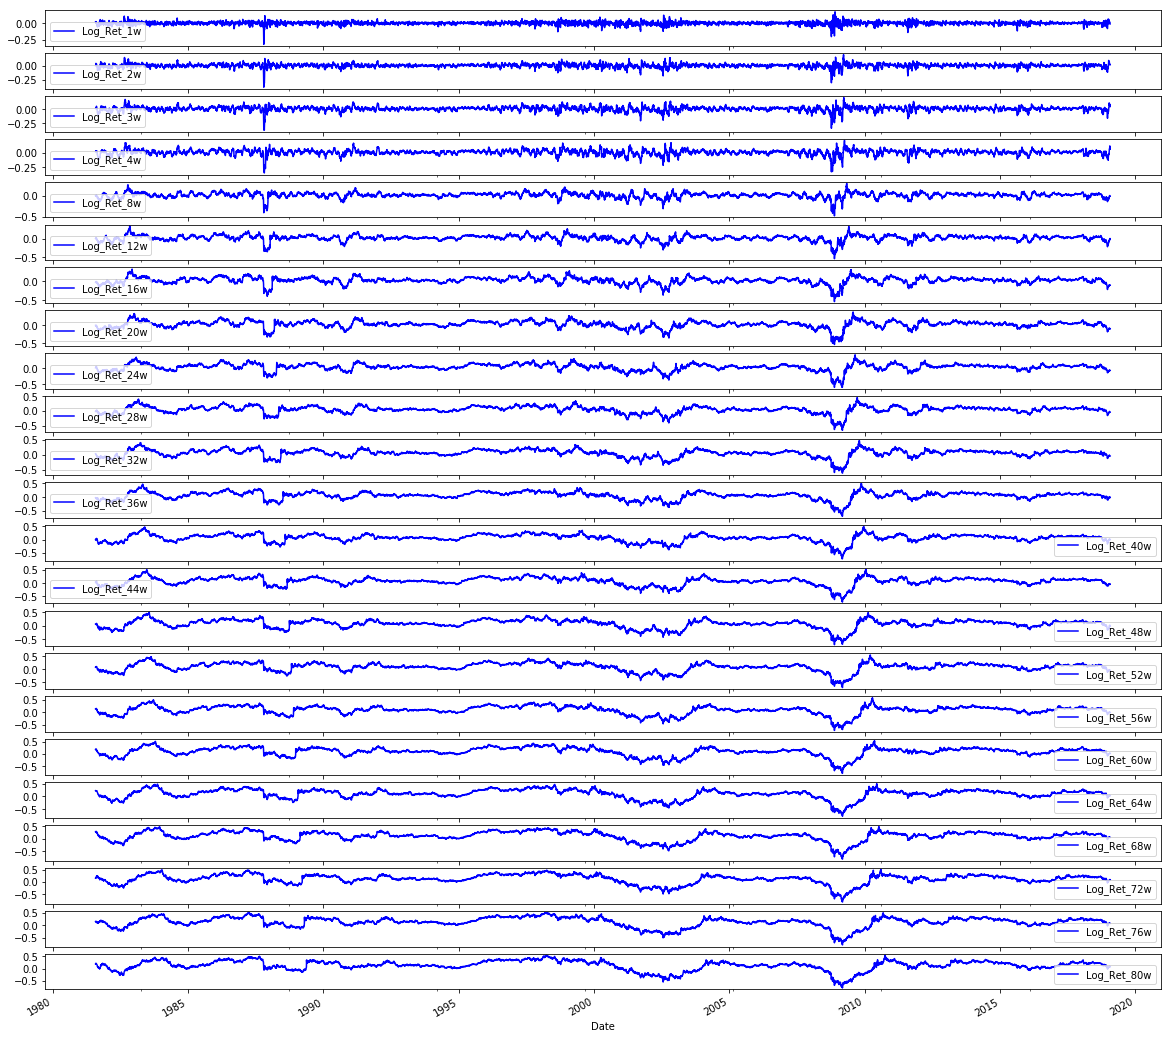

In [7]:
# Plot the logarithmic returns
sp500.iloc[:,1:24].plot(subplots=True, color='blue', figsize=(20, 20));

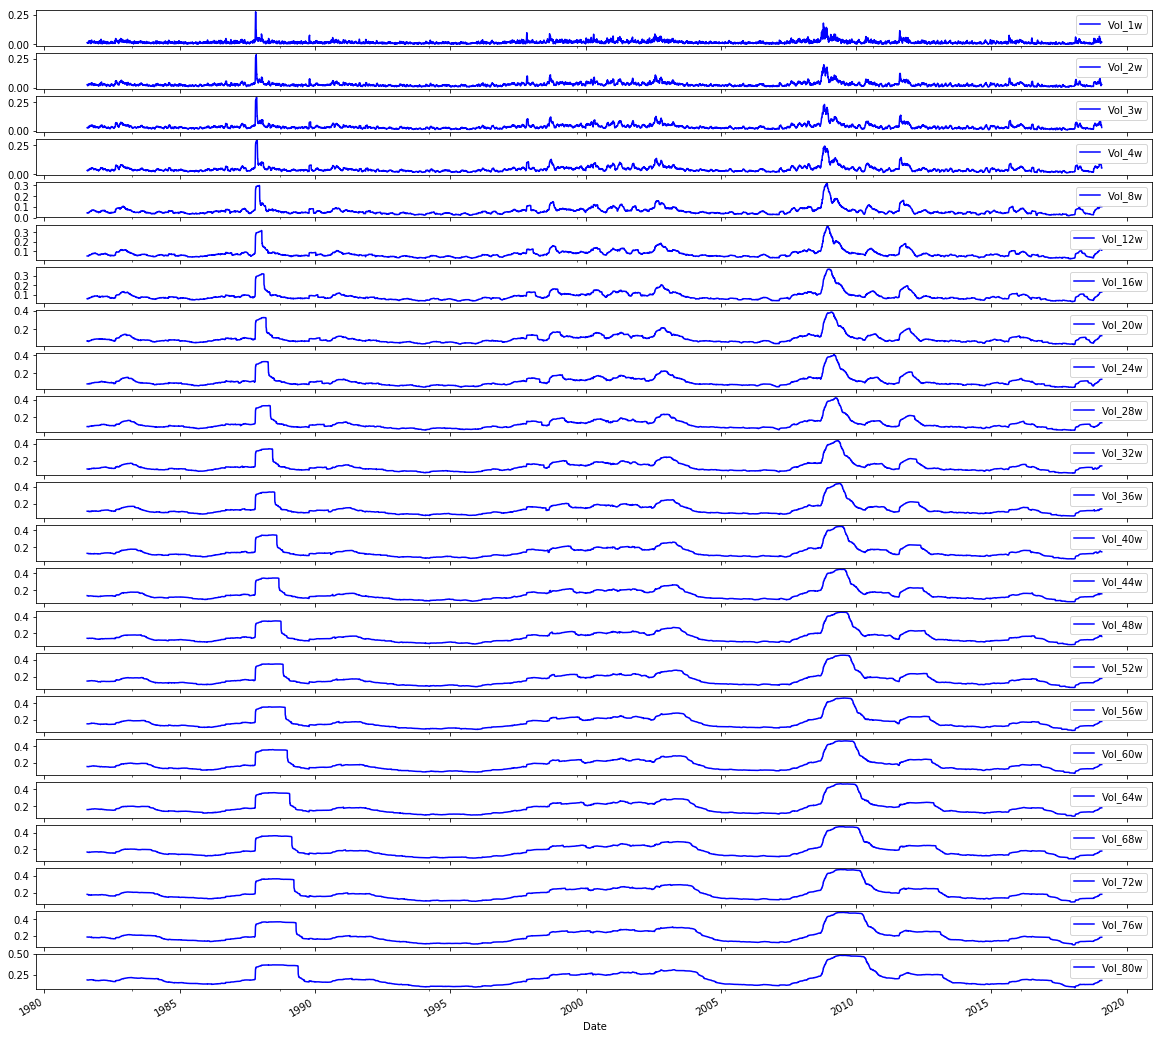

In [8]:
# Plot the Volatilities
sp500.iloc[:,24:47].plot(subplots=True, color='blue',figsize=(20, 20));

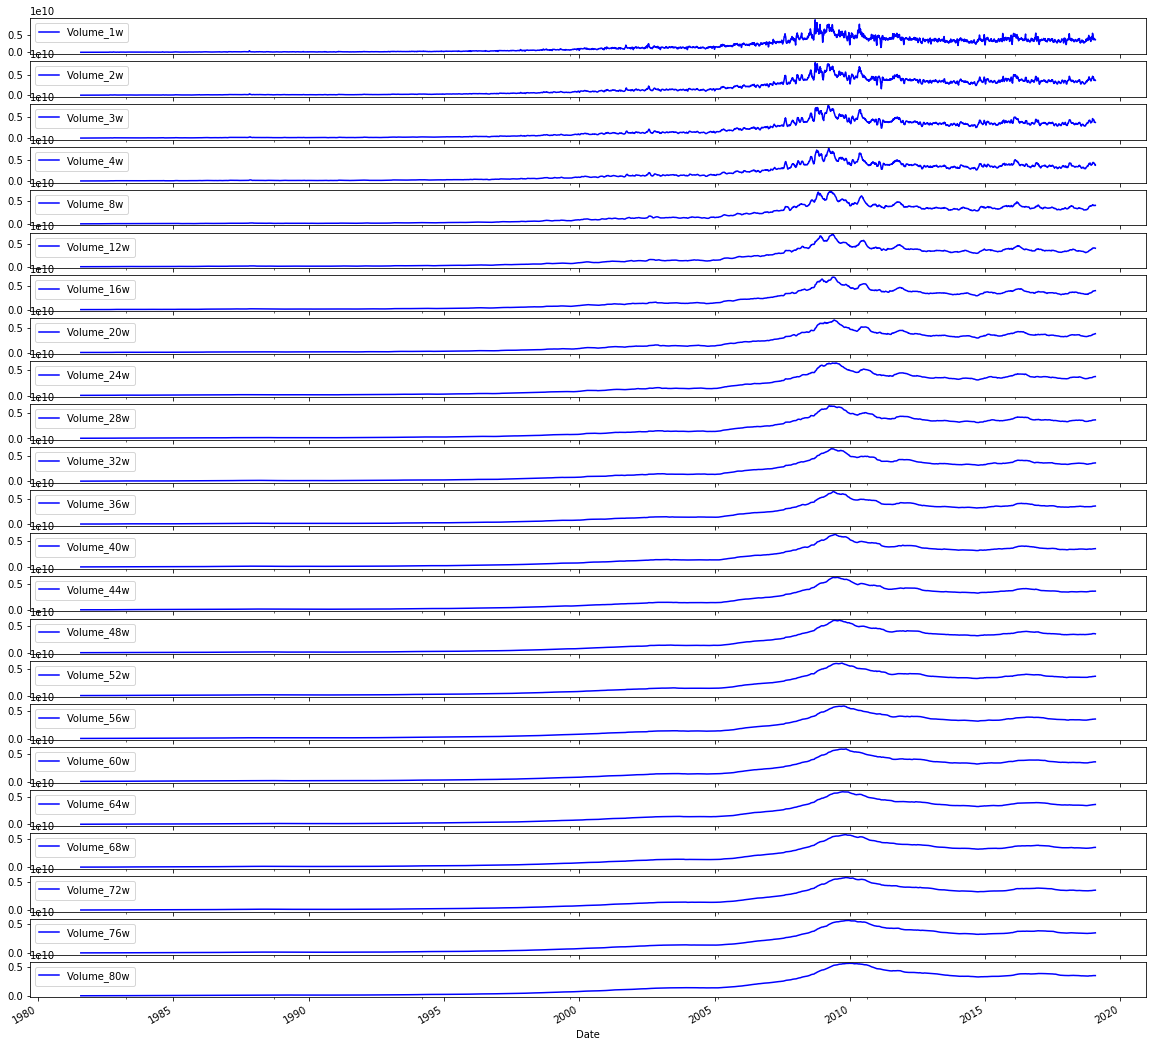

In [9]:
# Plot the Volumes
sp500.iloc[:,47:70].plot(subplots=True, color='blue', figsize=(20, 20));

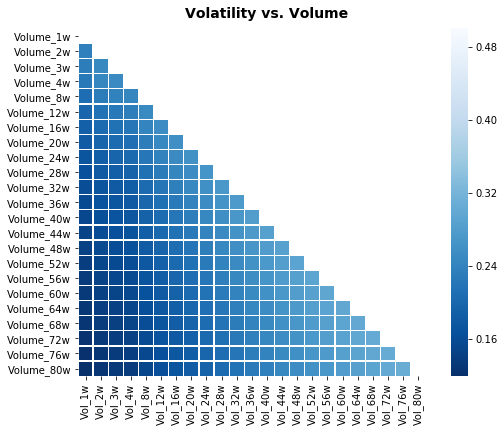

In [8]:
# Plot correlation matrix

focus_cols=sp500.iloc[:,24:47].columns 

corr=sp500.iloc[:,24:70].corr().filter(focus_cols).drop(focus_cols)

mask=np.zeros_like(corr); mask[np.triu_indices_from(mask)]=True # we use mask to plot only part of the matrix

heat_fig, (ax)=plt.subplots(1, 1, figsize=(9,6))

heat=sns.heatmap(corr, 
                   ax=ax, 
                   mask=mask, 
                   vmax=.5, 
                   square=True, 
                   linewidths=.2, 
                   cmap="Blues_r")

heat_fig.subplots_adjust(top=.93)

heat_fig.suptitle('Volatility vs. Volume', fontsize=14, fontweight='bold')

plt.savefig('heat1.eps', dpi=200, format='eps');

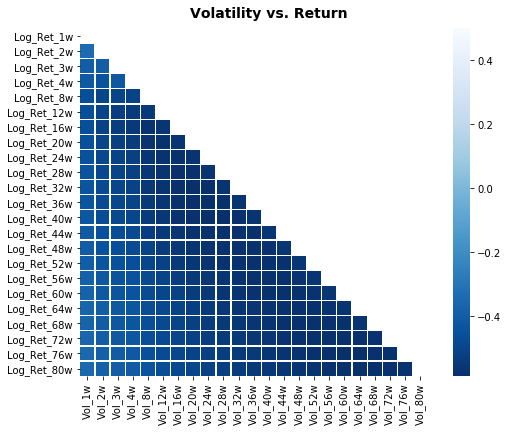

In [9]:
# Plot correlation matrix

focus_cols=sp500.iloc[:,24:47].columns 

corr=sp500.iloc[:,1:47].corr().filter(focus_cols).drop(focus_cols)

mask=np.zeros_like(corr); mask[np.triu_indices_from(mask)]=True # we use mask to plot only part of the matrix

heat_fig, (ax)=plt.subplots(1, 1, figsize=(9,6))

heat=sns.heatmap(corr, 
                   ax=ax, 
                   mask=mask, 
                   vmax=.5, 
                   square=True, 
                   linewidths=.2, 
                   cmap="Blues_r")

heat_fig.subplots_adjust(top=.93)

heat_fig.suptitle('Volatility vs. Return', fontsize=14, fontweight='bold')

plt.savefig('heat2.eps', dpi=200, format='eps');

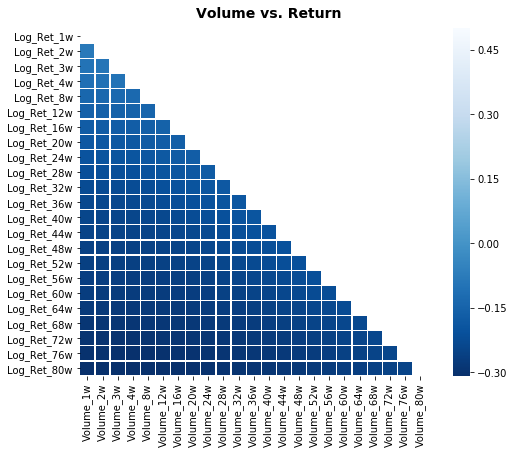

In [36]:
# Plot correlation matrix

focus_cols=sp500.iloc[:,47:70].columns 

corr=sp500.iloc[:, np.r_[1:24, 47:70]].corr().filter(focus_cols).drop(focus_cols)

mask=np.zeros_like(corr); mask[np.triu_indices_from(mask)]=True # we use mask to plot only part of the matrix

heat_fig, (ax)=plt.subplots(1, 1, figsize=(9,6))

heat=sns.heatmap(corr, 
                   ax=ax, 
                   mask=mask, 
                   vmax=.5, 
                   square=True, 
                   linewidths=.2, 
                   cmap="Blues_r")

heat_fig.subplots_adjust(top=.93)

heat_fig.suptitle('Volume vs. Return', fontsize=14, fontweight='bold')

plt.savefig('heat3.eps', dpi=200, format='eps');

## 4.5 Separate Test Data & Generate Model Sets for Baseline and LSTM Models 

In [11]:
# Model Set 1: Volatility

# Baseline
X_train_1, X_test_1, y_train_1, y_test_1=train_test_split(sp500.iloc[:,24:47], sp500.iloc[:,70], test_size=0.1 ,shuffle=False, stratify=None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_1_lstm=X_train_1.values.reshape(X_train_1.shape[0], 1, X_train_1.shape[1])
X_test_1_lstm=X_test_1.values.reshape(X_test_1.shape[0], 1, X_test_1.shape[1])

# Model Set 2: Return
X_train_2, X_test_2, y_train_2, y_test_2=train_test_split(sp500.iloc[:,1:24], sp500.iloc[:,70], test_size=0.1 ,shuffle=False, stratify=None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_2_lstm=X_train_2.values.reshape(X_train_2.shape[0], 1, X_train_2.shape[1])
X_test_2_lstm=X_test_2.values.reshape(X_test_2.shape[0], 1, X_test_2.shape[1])

# Model Set 3: Volume
X_train_3, X_test_3, y_train_3, y_test_3=train_test_split(sp500.iloc[:,47:70], sp500.iloc[:,70], test_size=0.1 ,shuffle=False, stratify=None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_3_lstm=X_train_3.values.reshape(X_train_3.shape[0], 1, X_train_3.shape[1])
X_test_3_lstm=X_test_3.values.reshape(X_test_3.shape[0], 1, X_test_3.shape[1])

# Model Set 4: Volatility and Return
X_train_4, X_test_4, y_train_4, y_test_4=train_test_split(sp500.iloc[:,1:47], sp500.iloc[:,70], test_size=0.1 ,shuffle=False, stratify=None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_4_lstm=X_train_4.values.reshape(X_train_4.shape[0], 1, X_train_4.shape[1])
X_test_4_lstm=X_test_4.values.reshape(X_test_4.shape[0], 1, X_test_4.shape[1])

# Model Set 5: Volatility and Volume
X_train_5, X_test_5, y_train_5, y_test_5=train_test_split(sp500.iloc[:,24:70], sp500.iloc[:,70], test_size=0.1 ,shuffle=False, stratify=None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_5_lstm=X_train_5.values.reshape(X_train_5.shape[0], 1, X_train_5.shape[1])
X_test_5_lstm=X_test_5.values.reshape(X_test_5.shape[0], 1, X_test_5.shape[1])

# Model Set 6: Return and Volume
X_train_6, X_test_6, y_train_6, y_test_6=train_test_split(pd.concat([sp500.iloc[:,1:24], sp500.iloc[:,47:70]], axis=1), sp500.iloc[:,70], test_size=0.1 ,shuffle=False, stratify=None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_6_lstm=X_train_6.values.reshape(X_train_6.shape[0], 1, X_train_6.shape[1])
X_test_6_lstm=X_test_6.values.reshape(X_test_6.shape[0], 1, X_test_6.shape[1])

# Model Set 7: Volatility, Return and Volume
X_train_7, X_test_7, y_train_7, y_test_7=train_test_split(sp500.iloc[:,1:70], sp500.iloc[:,70], test_size=0.1 ,shuffle=False, stratify=None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_7_lstm=X_train_7.values.reshape(X_train_7.shape[0], 1, X_train_7.shape[1])
X_test_7_lstm=X_test_7.values.reshape(X_test_7.shape[0], 1, X_test_7.shape[1])

## 4.6 Show Label Distribution

In [74]:
print("train set increase bias = "+ str(np.mean(y_train_7==1))+"%")

print("test set increase bias = " + str(np.mean(y_test_7==1))+"%")

train set increase bias = 0.6243535496003761%
test set increase bias = 0.6437632135306554%


# 5. Workflow

<img src="work-flow.png" width="800" />

### Walk Forward Cross-Validation

Time Series cross-validator provides train/dev indices to split time series data samples that are observed at fixed time intervals, in train/dev sets. In each split, dev indices must be higher than before, and thus shuffling in cross validator is inappropriate. The following graph illustrates how the time series split works:


<img src="walk-forward.png" width="800" />

In [12]:
# Time Series Split 
dev_size=0.1 
n_splits=int((1//dev_size)-1)   # using // for integer division
tscv=TimeSeriesSplit(n_splits=n_splits) 

## Scaling (Standardization/Normalization)

The splitting of the data set during cross-validation should be done before doing any preprocessing. Any process that extracts knowledge from the dataset should only ever be applied to the training portion of the data set, so any cross-validation should be the “outermost loop” in our processing. <br>

The Pipeline class is a class that allows “gluing” together multiple processing steps into a single scikit-learn estimator. The Pipeline class itself has fit, predict and score methods and behaves just like any other model in scikit-learn. The most common use-case of the pipeline class is in chaining preprocessing steps (like scaling of the data) together with a supervised model like a classifier. <br>

For each split in the Walk-Forward CV, the Scaler is refit with only the Sub training splits, not leaking any information of the test split into the parameter search, as illustrated below. 


<img src="scaling.png" width="800" />

**The preprocessing includes the following steps:** <br>
**Step 0**: The data is split into TRAINING data and VALIDATION data according to the cv parameter that we specified in the GridSearchCV or RandomizedSearchCV <br>
**Step 1**: the scaler is fitted on the TRAINING data <br>
**Step 2**: the scaler transforms TRAINING data <br>
**Step 3**: the models are fitted/trained using the transformed TRAINING data <br>
**Step 4**: the scaler is used to transform the VALIDATION data <br>
**Step 5**: the trained models predict using the transformed VALIDATION data <br>
**Step 6**: the scaler is fitted on the TRAINING and VALIDATION data <br>
**Step 7**: the scaler transforms TRAINING and VALIDATION data <br>
**Step 8**: the model is fitted/trained using the transformed TRAINING and VALIDATION data and the best found parameters during Walk-Forward CV<br>
**Step 9**: the scaler transforms TEST data <br>
**Step 10**: the trained model predicts using the transformed TEST data <br>

## 6 Regularization 

Regularization adds a penalty on the different parameters of the **baseline** model to reduce the freedom of the model. Hence, the model will be less likely to fit the noise of the training data and will improve the generalization abilities of the mode


### 6.1 L2 Regularization (Ridge penalisation)

The L2 regularization adds a penalty equal to the sum of the squared value of the coefficients.

$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a_{i}, y_{i}) + \lambda\sum_{i=1}^m\beta_{i}^2\tag{1}$$

The λ parameter is a scalar that should be learned as well, using walk-forward-cross-validation.

L2 regularization will force the **parameters to be relatively small**, the bigger the penalization, the smaller (and the more robust) the coefficients are.

<img src="ridge.png" width="500" />






### 6.2 L1 Regularization (Lasso penalisation)

The L1 regularization adds a penalty equal to the sum of the absolute value of the coefficients. 

$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a_{i}, y_{i}) + \lambda\sum_{i=1}^m|\beta_{i}|\tag{2}$$

The λ parameter is a scalar that should be learned as well, using walk-forward-cross-validation.

L1 regularization will **shrink some parameters to zero**. Hence some variables will not play any role in the model, L1 regression can be seen as a way to select features in a model. 


<img src="lasso.png" width="500" />


### 6.3 Elastic Net 

Elastic-net is a **mix of both L1 and L2 regularizations**. A penalty is applied to the sum of the absolute values and to the sum of the squared values:

$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a_{i}, y_{i}) + \lambda((1-\alpha)\sum_{i=1}^m\beta{i}^2+\alpha\sum_{i=1}^m|\beta_{i}|)\tag{3}$$ 

Lambda is a shared penalization parameter while alpha sets the ratio between L1 and L2 regularization in the Elastic Net Regularization. Hence, we expect a hybrid behavior between L1 and L2 regularization.

Though coefficients are cut, the cut is less abrupt than the cut with lasso penalization alone. 

# Models

### Configuration Baseline Models

In [13]:
# Standardized Data
steps_b=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), 
           ('logistic', linear_model.SGDClassifier(loss="log", shuffle=False, early_stopping=False, tol=1e-3, random_state=1))]

#Normalized Data
#steps_b=[('scaler', MinMaxScaler(feature_range=(0, 1), copy=True)), 
#         ('logistic', linear_model.SGDClassifier(loss="log", shuffle=False, early_stopping=False, tol=1e-3, random_state=1))]

pipeline_b=Pipeline(steps_b) # Using a pipeline we glue together the Scaler & the Classifier
# This ensure that during cross validation the Scaler is fitted to only the training folds

# Penalties
penalty_b=['l1', 'l2', 'elasticnet']

# Evaluation Metric
scoring_b={'AUC': 'roc_auc', 'accuracy': make_scorer(accuracy_score)} #multiple evaluation metrics
metric_b='accuracy' #scorer is used to find the best parameters for refitting the estimator at the end

### Configuration LSTM Models

In [14]:
# Batch_input_shape=[1, 1, Z]  -> (batch size, time steps, number of features) 
# Data set inputs(trainX)=[X, 1, Z]  -> (samples, time steps, number of features)  

# number of samples
num_samples=1 
# time_steps
look_back=1


# Evaluation Metric
scoring_lstm='accuracy' 

# 6. Models

## Model 1: Volatility

## Baseline 

Loss function: log
accuracy of the best model:  0.5448412698412698


Best hyperparameters:
Number of iterations: 8
Penalty: l2
Alpha: 0.0014
l1_ratio: 0
Total number of features: 23
Number of selected features: 23


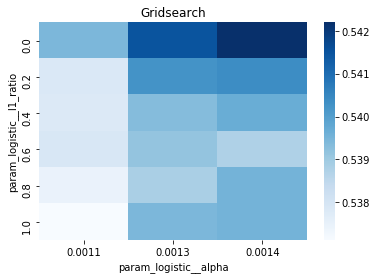

In [84]:
# Model specific Parameter 

# Number of iterations
iterations_1_b=[8] 


# Grid Search

# Regularization  
alpha_g_1_b=[0.0011, 0.0013, 0.0014] #0.0011, 0.0012, 0.0013
l1_ratio_g_1_b=[0, 0.2, 0.4, 0.6, 0.8, 1] 

# Create hyperparameter options
hyperparameters_g_1_b={'logistic__alpha':alpha_g_1_b, 
                       'logistic__l1_ratio':l1_ratio_g_1_b, 
                       'logistic__penalty':penalty_b,  
                       'logistic__max_iter':iterations_1_b}

# Create grid search 
search_g_1_b=GridSearchCV(estimator=pipeline_b, 
                            param_grid=hyperparameters_g_1_b, 
                            cv=tscv, 
                            verbose=0, 
                            n_jobs=-1, 
                            scoring=scoring_b, 
                            refit=metric_b, 
                            return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated mean Accuracy score. 
# For multiple metric evaluation, this needs to be a string denoting the scorer is used to find the best parameters for refitting the estimator at the end
# If return_train_score=True training results of CV will be saved as well 

# Fit grid search
tuned_model_1_b=search_g_1_b.fit(X_train_1, y_train_1)
#search_g_1_b.cv_results_


# Random Search

# Create regularization hyperparameter distribution using uniform distribution
#alpha_r_1_b=uniform(loc=0.00006, scale=0.002) 
#l1_ratio_r_1_b=uniform(loc=0, scale=1) 

# Create hyperparameter options
#hyperparameters_r_1_b={'logistic__alpha':alpha_r_1_b, 'logistic__l1_ratio':l1_ratio_r_1_b, 'logistic__penalty':penalty_b,'logistic__max_iter':iterations_1_b}

# Create randomized search 
#search_r_1_b=RandomizedSearchCV(pipeline_b, 
#                                  hyperparameters_r_1_b, 
#                                  n_iter=10, 
#                                  random_state=1, 
#                                  cv=tscv, 
#                                  verbose=0, 
#                                  n_jobs=-1, 
#                                  scoring=scoring_b, 
#                                  refit=metric_b, 
#                                  return_train_score=True)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated Accuracy score.
# For multiple metric evaluation, this needs to be a string denoting the scorer is used to find the best parameters for refitting the estimator at the end
# If return_train_score=True training results of CV will be saved as well  

# Fit randomized search
#tuned_model_1_b=search_r_1_b.fit(X_train_1, y_train_1)



# View Cost function
print('Loss function:', tuned_model_1_b.best_estimator_.get_params()['logistic__loss'])

# View Accuracy 
print(metric_b +' of the best model: ', tuned_model_1_b.best_score_);print("\n")
# best_score_ Mean cross-validated score of the best_estimator

# View best hyperparameters
print("Best hyperparameters:")
print('Number of iterations:', tuned_model_1_b.best_estimator_.get_params()['logistic__max_iter'])
print('Penalty:', tuned_model_1_b.best_estimator_.get_params()['logistic__penalty'])
print('Alpha:', tuned_model_1_b.best_estimator_.get_params()['logistic__alpha'])
print('l1_ratio:', tuned_model_1_b.best_estimator_.get_params()['logistic__l1_ratio'])

# Find the number of nonzero coefficients (selected features)
print("Total number of features:", len(tuned_model_1_b.best_estimator_.steps[1][1].coef_[0][:]))
print("Number of selected features:", np.count_nonzero(tuned_model_1_b.best_estimator_.steps[1][1].coef_[0][:]))

# Gridsearch table
plt.title('Gridsearch')
pvt_1_b=pd.pivot_table(pd.DataFrame(tuned_model_1_b.cv_results_), values='mean_test_accuracy', index='param_logistic__l1_ratio', columns='param_logistic__alpha')
ax_1_b=sns.heatmap(pvt_1_b, cmap="Blues")
plt.show()

### Confusion Matrix

Accuracy: 0.6501057082452432
Precision: 0.6565315315315315
Recall: 0.9573070607553367


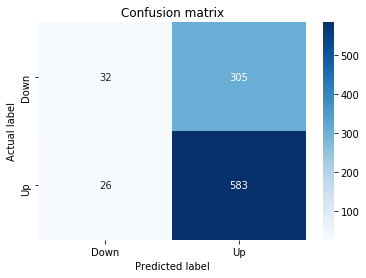

In [85]:
# Make predictions
y_pred_1_b=tuned_model_1_b.predict(X_test_1)

# create confustion matrix
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_1, y_pred_1_b)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_1, y_pred_1_b))
print("Precision:",metrics.precision_score(y_test_1, y_pred_1_b))
print("Recall:",metrics.recall_score(y_test_1, y_pred_1_b))

### ROC Curve

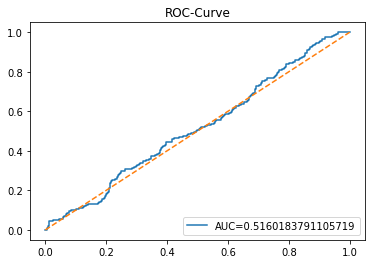

In [86]:
y_proba_1_b=tuned_model_1_b.predict_proba(X_test_1)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_1,  y_proba_1_b)
auc=metrics.roc_auc_score(y_test_1, y_proba_1_b)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

## LSTM Model 

In [720]:
start=time.time()

# number of epochs
epochs=1
# number of units 
LSTM_units_1_lstm=195
# numer of features
num_features_1_lstm=X_train_1.shape[1]
# Regularization
dropout_rate=0.1
recurrent_dropout=0.1 # 0.21
# print
verbose=0

#hyperparameter
batch_size=[1] 

# hyperparameter
hyperparameter_1_lstm={'batch_size':batch_size}


# create Classifier
clf_1_lstm=KerasClassifier(build_fn=create_shallow_LSTM, 
                          epochs=epochs, 
                          LSTM_units=LSTM_units_1_lstm, 
                          num_samples=num_samples, 
                          look_back=look_back, 
                          num_features=num_features_1_lstm, 
                          dropout_rate=dropout_rate,
                          recurrent_dropout=recurrent_dropout,
                          verbose=verbose)
# Gridsearch
search_1_lstm=GridSearchCV(estimator=clf_1_lstm, 
                          param_grid=hyperparameter_1_lstm,  
                          n_jobs=-1,  
                          cv=tscv, 
                          scoring=scoring_lstm, # accuracy
                          refit=True, 
                          return_train_score=False)

# Fit model
tuned_model_1_lstm=search_1_lstm.fit(X_train_1_lstm, y_train_1, shuffle=False, callbacks=[reset])



print("\n")

# View Accuracy 
print(scoring_lstm +' of the best model: ', tuned_model_1_lstm.best_score_)
# best_score_ Mean cross-validated score of the best_estimator

print("\n")

# View best hyperparameters
print("Best hyperparameters:")
print('epochs:', tuned_model_1_lstm.best_estimator_.get_params()['epochs'])
print('batch_size:', tuned_model_1_lstm.best_estimator_.get_params()['batch_size'])
print('dropout_rate:', tuned_model_1_lstm.best_estimator_.get_params()['dropout_rate'])
print('recurrent_dropout:', tuned_model_1_lstm.best_estimator_.get_params()['recurrent_dropout'])

end=time.time()
print("\n")
print("Running Time:", end - start)



accuracy of the best model:  0.6101851851851852


Best hyperparameters:
epochs: 1
batch_size: 1
dropout_rate: 0.1
recurrent_dropout: 0.1


Running Time: 241.70626878738403


### Confusion Matrix

Accuracy: 0.6437632135306554
Precision: 0.6437632135306554
Recall: 1.0


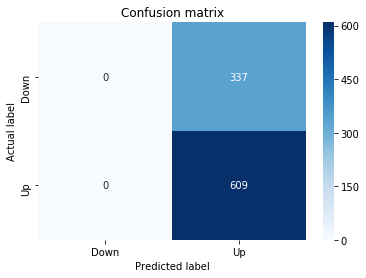

In [721]:
# Make predictions
y_pred_1_lstm=tuned_model_1_lstm.predict(X_test_1_lstm)

# create confustion matrix
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_1, y_pred_1_lstm)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_1, y_pred_1_lstm))
print("Precision:",metrics.precision_score(y_test_1, y_pred_1_lstm))
print("Recall:",metrics.recall_score(y_test_1, y_pred_1_lstm))

### ROC Curve

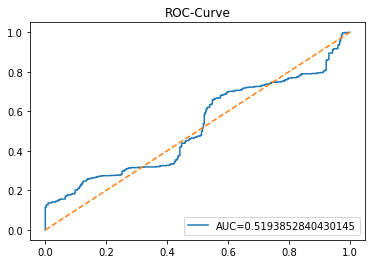

In [23]:
y_proba_1_lstm=tuned_model_1_lstm.predict_proba(X_test_1_lstm)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_1,  y_proba_1_lstm)
auc=metrics.roc_auc_score(y_test_1, y_proba_1_lstm)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

# Model 2: Return

### Baseline

Loss function: log
accuracy of the best model:  0.5543650793650794


Best hyperparameters:
Number of iterations: 8
Penalty: elasticnet
Alpha: 0.0013
l1_ratio: 0.4
Total number of features: 23
Number of selected features: 10


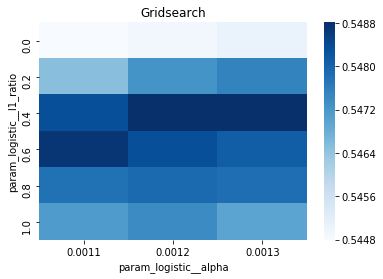

In [24]:
# Model specific Parameter 

# Number of iterations
iterations_2_b=[8] 


# Grid Search

# Regularization  
alpha_g_2_b=[0.0011, 0.0012, 0.0013]
l1_ratio_g_2_b=[0, 0.2, 0.4, 0.6, 0.8, 1] 

# Create hyperparameter options
hyperparameters_g_2_b={'logistic__alpha':alpha_g_2_b, 
                       'logistic__l1_ratio':l1_ratio_g_2_b, 
                       'logistic__penalty':penalty_b,  
                       'logistic__max_iter':iterations_2_b}

# Create grid search 
search_g_2_b=GridSearchCV(estimator=pipeline_b, 
                          param_grid=hyperparameters_g_2_b, 
                          cv=tscv, 
                          verbose=0, 
                          n_jobs=-1, 
                          scoring=scoring_b, 
                          refit=metric_b, 
                          return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated mean Accuracy score. 
# For multiple metric evaluation, this needs to be a string denoting the scorer is used to find the best parameters for refitting the estimator at the end
# If return_train_score=True training results of CV will be saved as well 

# Fit grid search
tuned_model_2_b=search_g_2_b.fit(X_train_2, y_train_2)
#search_g_2_b.cv_results_


# Random Search

# Create regularization hyperparameter distribution using uniform distribution
#alpha_r_2_b=uniform(loc=0.00006, scale=0.002) #loc=0.00006, scale=0.002
#l1_ratio_r_2_b=uniform(loc=0, scale=1) 

# Create hyperparameter options
#hyperparameters_r_2_b={'logistic__alpha':alpha_r_2_b, 'logistic__l1_ratio':l1_ratio_r_2_b, 'logistic__penalty':penalty_b,'logistic__max_iter':iterations_2_b}

# Create randomized search 
#search_r_2_b=RandomizedSearchCV(pipeline_b, hyperparameters_r_2_b, n_iter=10, random_state=1, cv=tscv, verbose=0, n_jobs=-1, scoring=scoring_b, refit=metric_b, return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated Accuracy score.

# Fit randomized search
#tuned_model_2_b=search_r_2_b.fit(X_train_2, y_train_2)



# View Cost function
print('Loss function:', tuned_model_2_b.best_estimator_.get_params()['logistic__loss'])

# View Accuracy 
print(metric_b +' of the best model: ', tuned_model_2_b.best_score_);print("\n")
# best_score_ Mean cross-validated score of the best_estimator

# View best hyperparameters
print("Best hyperparameters:")
print('Number of iterations:', tuned_model_2_b.best_estimator_.get_params()['logistic__max_iter'])
print('Penalty:', tuned_model_2_b.best_estimator_.get_params()['logistic__penalty'])
print('Alpha:', tuned_model_2_b.best_estimator_.get_params()['logistic__alpha'])
print('l1_ratio:', tuned_model_2_b.best_estimator_.get_params()['logistic__l1_ratio'])

# Find the number of nonzero coefficients (selected features)
print("Total number of features:", len(tuned_model_2_b.best_estimator_.steps[1][1].coef_[0][:]))
print("Number of selected features:", np.count_nonzero(tuned_model_2_b.best_estimator_.steps[1][1].coef_[0][:]))

# Gridsearch table
plt.title('Gridsearch')
pvt_2_b=pd.pivot_table(pd.DataFrame(tuned_model_2_b.cv_results_), values='mean_test_accuracy', index='param_logistic__l1_ratio', columns='param_logistic__alpha')
ax_2_b=sns.heatmap(pvt_2_b, cmap="Blues")
plt.show()

### Confusion Matrix

Accuracy: 0.6606765327695561
Precision: 0.6607142857142857
Recall: 0.9720853858784894


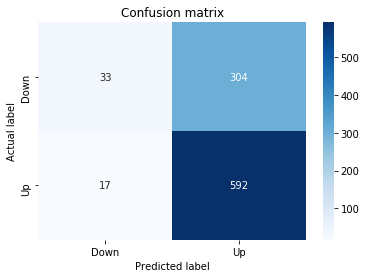

In [25]:
# Make predictions
y_pred_2_b=tuned_model_2_b.predict(X_test_2)

# create confustion matrix
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_2, y_pred_2_b)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_2, y_pred_2_b))
print("Precision:",metrics.precision_score(y_test_2, y_pred_2_b))
print("Recall:",metrics.recall_score(y_test_2, y_pred_2_b))

### ROC Curve

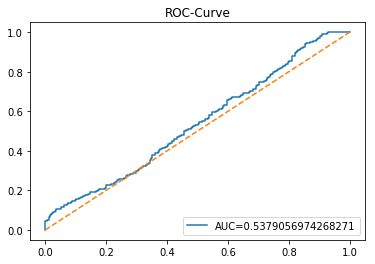

In [26]:
y_proba_2_b=tuned_model_2_b.predict_proba(X_test_2)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_2,  y_proba_2_b)
auc=metrics.roc_auc_score(y_test_2, y_proba_2_b)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

## LSTM

In [27]:
start=time.time()


# number of epochs
epochs=1
# number of units 
LSTM_units_2_lstm=180
# number of samples
num_samples=1 
# time_steps
look_back=1
# numer of features
num_features_2_lstm=X_train_2.shape[1]
# Regularization
dropout_rate=0.
recurrent_dropout=0.4
# print
verbose=0

#hyperparameter
batch_size=[1] 

# hyperparameter
hyperparameter_2_lstm={'batch_size':batch_size}


# create Classifier
clf_2_lstm=KerasClassifier(build_fn=create_shallow_LSTM, 
                           epochs=epochs, 
                           LSTM_units=LSTM_units_2_lstm, 
                           num_samples=num_samples, 
                           look_back=look_back, 
                           num_features=num_features_2_lstm, 
                           dropout_rate=dropout_rate,
                           recurrent_dropout=recurrent_dropout,
                           verbose=verbose)
# Gridsearch
search_2_lstm=GridSearchCV(estimator=clf_2_lstm, 
                           param_grid=hyperparameter_2_lstm,  
                           n_jobs=-1,  
                           cv=tscv, 
                           scoring=scoring_lstm, # accuracy
                           refit=True, 
                           return_train_score=False)

# Fit model
tuned_model_2_lstm=search_2_lstm.fit(X_train_2_lstm, y_train_2, shuffle=False, callbacks=[reset])



print("\n")

# View Accuracy 
print(scoring_lstm +' of the best model: ', tuned_model_2_lstm.best_score_)
# best_score_ Mean cross-validated score of the best_estimator

print("\n")

# View best hyperparameters
print("Best hyperparameters:")
print('epochs:', tuned_model_2_lstm.best_estimator_.get_params()['epochs'])
print('batch_size:', tuned_model_2_lstm.best_estimator_.get_params()['batch_size'])
print('dropout_rate:', tuned_model_2_lstm.best_estimator_.get_params()['dropout_rate'])
print('recurrent_dropout:', tuned_model_2_lstm.best_estimator_.get_params()['recurrent_dropout'])

end=time.time()
print("\n")
print("Running Time:", end - start)



accuracy of the best model:  0.5562169312169312


Best hyperparameters:
epochs: 1
batch_size: 1
dropout_rate: 0.0
recurrent_dropout: 0.4


Running Time: 203.3864288330078


### Confusion Matrix

Accuracy: 0.6501057082452432
Precision: 0.6551339285714286
Recall: 0.9638752052545156


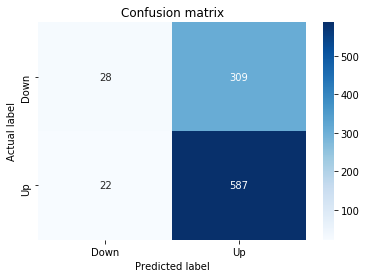

In [28]:
# Make predictions
y_pred_2_lstm=tuned_model_2_lstm.predict(X_test_2_lstm)

# create confustion matrix
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_2, y_pred_2_lstm)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_2, y_pred_2_lstm))
print("Precision:",metrics.precision_score(y_test_2, y_pred_2_lstm))
print("Recall:",metrics.recall_score(y_test_2, y_pred_2_lstm))

### ROC Curve

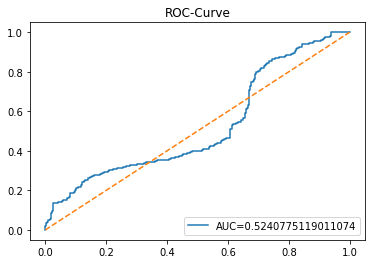

In [29]:
y_proba_2_lstm=tuned_model_2_lstm.predict_proba(X_test_2_lstm)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_2,  y_proba_2_lstm)
auc=metrics.roc_auc_score(y_test_2, y_proba_2_lstm)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

# Model 3: Trading Volume 

### Baseline

Loss function: log
accuracy of the best model:  0.5521164021164021


Best hyperparameters:
Number of iterations: 20
Penalty: l1
Alpha: 1.836230045470262e-05
l1_ratio: 0.9168613345297285
Total number of features: 23
Number of selected features: 6


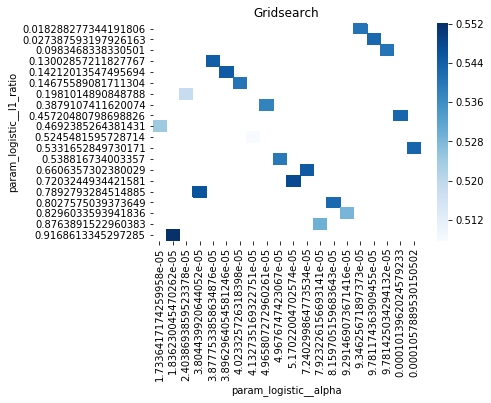

In [599]:
# Model specific Parameter 

# Number of iterations
#iterations_3_b=[20] 


# Grid Search

# Regularization  
#alpha_g_3_b=[0.00007, 0.00008, 0.00009] 
#l1_ratio_g_3_b=[0., 0.2, 0.4, 0.6, 0.8,  1] 

# Create hyperparameter options
#hyperparameters_g_3_b={'logistic__alpha':alpha_g_3_b, 
#                       'logistic__l1_ratio':l1_ratio_g_3_b, 
#                       'logistic__penalty':penalty_b,  
#                       'logistic__max_iter':iterations_3_b}

# Create grid search 
#search_g_3_b=GridSearchCV(estimator=pipeline_b, 
#                          param_grid=hyperparameters_g_3_b, 
#                          cv=tscv, 
#                          verbose=0, 
#                          n_jobs=-1, 
#                          scoring=scoring_b, 
#                          refit=metric_b, 
#                          return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated mean Accuracy score. 
# For multiple metric evaluation, this needs to be a string denoting the scorer is used to find the best parameters for refitting the estimator at the end
# If return_train_score=True training results of CV will be saved as well 

# Fit grid search
#tuned_model_3_b=search_g_3_b.fit(X_train_3, y_train_3)
#search_g_3_b.cv_results_


# Random Search

# Create regularization hyperparameter distribution using uniform distribution
alpha_r_3_b=uniform(loc=0.00001, scale=0.0001) 
l1_ratio_r_3_b=uniform(loc=0, scale=1) 

# Create hyperparameter options
hyperparameters_r_3_b={'logistic__alpha':alpha_r_3_b, 'logistic__l1_ratio':l1_ratio_r_3_b, 'logistic__penalty':penalty_b,'logistic__max_iter':iterations_3_b}

# Create randomized search  
search_r_3_b=RandomizedSearchCV(pipeline_b, hyperparameters_r_3_b, n_iter=20, random_state=1, cv=tscv, verbose=0, n_jobs=-1, scoring=scoring_b, refit=metric_b, return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated Accuracy score.

# Fit randomized search
tuned_model_3_b=search_r_3_b.fit(X_train_3, y_train_3)



# View Cost function
print('Loss function:', tuned_model_3_b.best_estimator_.get_params()['logistic__loss'])

# View Accuracy 
print(metric_b +' of the best model: ', tuned_model_3_b.best_score_);print("\n")
# best_score_ Mean cross-validated score of the best_estimator

# View best hyperparameters
print("Best hyperparameters:")
print('Number of iterations:', tuned_model_3_b.best_estimator_.get_params()['logistic__max_iter'])
print('Penalty:', tuned_model_3_b.best_estimator_.get_params()['logistic__penalty'])
print('Alpha:', tuned_model_3_b.best_estimator_.get_params()['logistic__alpha'])
print('l1_ratio:', tuned_model_3_b.best_estimator_.get_params()['logistic__l1_ratio'])

# Find the number of nonzero coefficients (selected features)
print("Total number of features:", len(tuned_model_3_b.best_estimator_.steps[1][1].coef_[0][:]))
print("Number of selected features:", np.count_nonzero(tuned_model_3_b.best_estimator_.steps[1][1].coef_[0][:]))

# Gridsearch table
plt.title('Gridsearch')
pvt_3_b=pd.pivot_table(pd.DataFrame(tuned_model_3_b.cv_results_), values='mean_test_accuracy', index='param_logistic__l1_ratio', columns='param_logistic__alpha')
ax_3_b=sns.heatmap(pvt_3_b, cmap="Blues")
plt.show()

### Confusion Matrix

Accuracy: 0.6395348837209303
Precision: 0.6434689507494646
Recall: 0.986863711001642


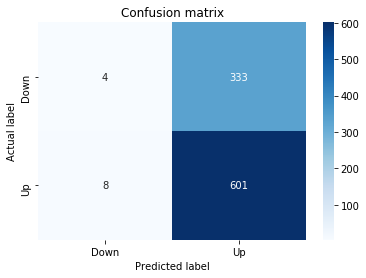

In [600]:
# Make predictions
y_pred_3_b=tuned_model_3_b.predict(X_test_3)

# create confustion matrix
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_3, y_pred_3_b)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_3, y_pred_3_b))
print("Precision:",metrics.precision_score(y_test_3, y_pred_3_b))
print("Recall:",metrics.recall_score(y_test_3, y_pred_3_b))

### ROC Curve

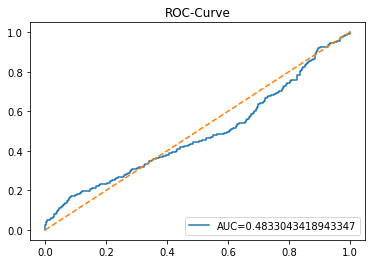

In [590]:
y_proba_3_b=tuned_model_3_b.predict_proba(X_test_3)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_3,  y_proba_3_b)
auc=metrics.roc_auc_score(y_test_3, y_proba_3_b)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

## LSTM

In [60]:
start=time.time()


# number of epochs
epochs=1
# number of units 
LSTM_units_3_lstm=180
# number of samples
num_samples=1 
# time_steps
look_back=1
# numer of features
num_features_3_lstm=X_train_3.shape[1]
# Regularization
dropout_rate=0.
recurrent_dropout=0.4
# print
verbose=0

#hyperparameter
batch_size=[1] 

# hyperparameter
hyperparameter_3_lstm={'batch_size':batch_size}


# create Classifier
clf_3_lstm=KerasClassifier(build_fn=create_shallow_LSTM, 
                           epochs=epochs, 
                           LSTM_units=LSTM_units_3_lstm, 
                           num_samples=num_samples, 
                           look_back=look_back, 
                           num_features=num_features_3_lstm, 
                           dropout_rate=dropout_rate,
                           recurrent_dropout=recurrent_dropout,
                           verbose=verbose)
# Gridsearch
search_3_lstm=GridSearchCV(estimator=clf_3_lstm, 
                           param_grid=hyperparameter_3_lstm,  
                           n_jobs=-1,  
                           cv=tscv, 
                           scoring=scoring_lstm, # accuracy
                           refit=True, 
                           return_train_score=False)

# Fit model
tuned_model_3_lstm=search_3_lstm.fit(X_train_3_lstm, y_train_3, shuffle=False, callbacks=[reset])



print("\n")

# View Accuracy 
print(scoring_lstm +' of the best model: ', tuned_model_3_lstm.best_score_)
# best_score_ Mean cross-validated score of the best_estimator

print("\n")

# View best hyperparameters
print("Best hyperparameters:")
print('epochs:', tuned_model_3_lstm.best_estimator_.get_params()['epochs'])
print('batch_size:', tuned_model_3_lstm.best_estimator_.get_params()['batch_size'])
print('dropout_rate:', tuned_model_3_lstm.best_estimator_.get_params()['dropout_rate'])
print('recurrent_dropout:', tuned_model_3_lstm.best_estimator_.get_params()['recurrent_dropout'])

end=time.time()
print("\n")
print("Running Time:", end - start)



accuracy of the best model:  0.56494708994709


Best hyperparameters:
epochs: 1
batch_size: 1
dropout_rate: 0.0
recurrent_dropout: 0.4


Running Time: 188.86053204536438


### Confusion Matrix

Accuracy: 0.6511627906976745
Precision: 0.6511375947995667
Recall: 0.986863711001642


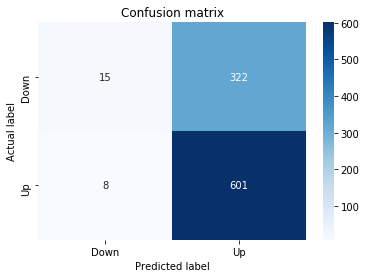

In [61]:
# Make predictions
y_pred_3_lstm=tuned_model_3_lstm.predict(X_test_3_lstm)

# create confustion matrix
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_3, y_pred_3_lstm)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_3, y_pred_3_lstm))
print("Precision:",metrics.precision_score(y_test_3, y_pred_3_lstm))
print("Recall:",metrics.recall_score(y_test_3, y_pred_3_lstm))

### ROC Curve

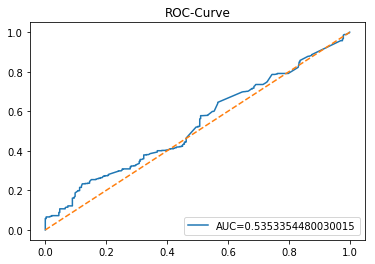

In [62]:
y_proba_3_lstm=tuned_model_3_lstm.predict_proba(X_test_3_lstm)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_3,  y_proba_3_lstm)
auc=metrics.roc_auc_score(y_test_3, y_proba_3_lstm)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

# Model 4: Volatility + Return

Loss function: log
accuracy of the best model:  0.5206349206349207


Best hyperparameters:
Number of iterations: 8
Penalty: elasticnet
Alpha: 0.0012
l1_ratio: 0.6
Total number of features: 46
Number of selected features: 19


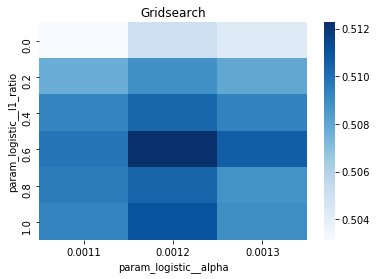

In [39]:
# Model specific Parameter 

# Number of iterations
iterations_4_b=[8] 


# Grid Search

# Regularization  
alpha_g_4_b=[0.0011, 0.0012, 0.0013]
l1_ratio_g_4_b=[0, 0.2, 0.4, 0.6, 0.8, 1] 

# Create hyperparameter options
hyperparameters_g_4_b={'logistic__alpha':alpha_g_4_b, 
                       'logistic__l1_ratio':l1_ratio_g_4_b, 
                       'logistic__penalty':penalty_b,  
                       'logistic__max_iter':iterations_4_b}

# Create grid search 
search_g_4_b=GridSearchCV(estimator=pipeline_b, 
                          param_grid=hyperparameters_g_4_b, 
                          cv=tscv, 
                          verbose=0, 
                          n_jobs=-1, 
                          scoring=scoring_b, 
                          refit=metric_b, 
                          return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated mean Accuracy score. 
# For multiple metric evaluation, this needs to be a string denoting the scorer is used to find the best parameters for refitting the estimator at the end
# If return_train_score=True training results of CV will be saved as well 

# Fit grid search
tuned_model_4_b=search_g_4_b.fit(X_train_4, y_train_4)
#search_g_4_b.cv_results_


# Random Search

# Create regularization hyperparameter distribution using uniform distribution
#alpha_r_4_b=uniform(loc=0.00006, scale=0.002) #loc=0.00006, scale=0.002
#l1_ratio_r_4_b=uniform(loc=0, scale=1) 

# Create hyperparameter options
#hyperparameters_r_4_b={'logistic__alpha':alpha_r_4_b, 'logistic__l1_ratio':l1_ratio_r_4_b, 'logistic__penalty':penalty_b,'logistic__max_iter':iterations_4_b}

# Create randomized search 
#search_r_4_b=RandomizedSearchCV(pipeline_b, hyperparameters_r_4_b, n_iter=10, random_state=1, cv=tscv, verbose=0, n_jobs=-1, scoring=scoring_b, refit=metric_b, return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated Accuracy score.

# Fit randomized search
#tuned_model_4_b=search_r_4_b.fit(X_train_4, y_train_4)



# View Cost function
print('Loss function:', tuned_model_4_b.best_estimator_.get_params()['logistic__loss'])

# View Accuracy 
print(metric_b +' of the best model: ', tuned_model_4_b.best_score_);print("\n")
# best_score_ Mean cross-validated score of the best_estimator

# View best hyperparameters
print("Best hyperparameters:")
print('Number of iterations:', tuned_model_4_b.best_estimator_.get_params()['logistic__max_iter'])
print('Penalty:', tuned_model_4_b.best_estimator_.get_params()['logistic__penalty'])
print('Alpha:', tuned_model_4_b.best_estimator_.get_params()['logistic__alpha'])
print('l1_ratio:', tuned_model_4_b.best_estimator_.get_params()['logistic__l1_ratio'])

# Find the number of nonzero coefficients (selected features)
print("Total number of features:", len(tuned_model_4_b.best_estimator_.steps[1][1].coef_[0][:]))
print("Number of selected features:", np.count_nonzero(tuned_model_4_b.best_estimator_.steps[1][1].coef_[0][:]))

# Gridsearch table
plt.title('Gridsearch')
pvt_4_b=pd.pivot_table(pd.DataFrame(tuned_model_4_b.cv_results_), values='mean_test_accuracy', index='param_logistic__l1_ratio', columns='param_logistic__alpha')
ax_4_b=sns.heatmap(pvt_4_b, cmap="Blues")
plt.show()

### Confusion Matrix

Accuracy: 0.6004228329809725
Precision: 0.6501950585175552
Recall: 0.8210180623973727


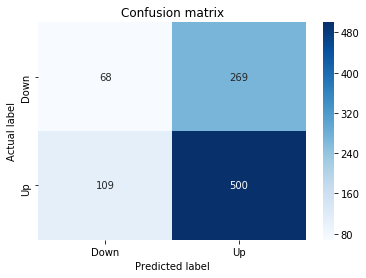

In [40]:
# Make predictions
y_pred_4_b=tuned_model_4_b.predict(X_test_4)

# create confustion matrix
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_4, y_pred_4_b)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_4, y_pred_4_b))
print("Precision:",metrics.precision_score(y_test_4, y_pred_4_b))
print("Recall:",metrics.recall_score(y_test_4, y_pred_4_b))

### ROC Curve

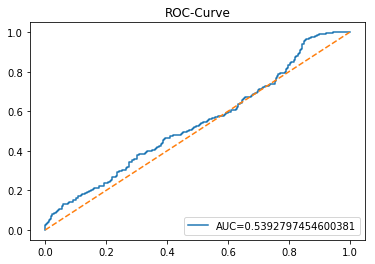

In [41]:
y_proba_4_b=tuned_model_4_b.predict_proba(X_test_4)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_4,  y_proba_4_b)
auc=metrics.roc_auc_score(y_test_4, y_proba_4_b)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

## LSTM

In [197]:
start=time.time()


# number of epochs
epochs=1
# number of units 
LSTM_units_4_lstm=200
# number of samples
num_samples=1 
# time_steps
look_back=1
# numer of features
num_features_4_lstm=X_train_4.shape[1]
# Regularization
dropout_rate=0.
recurrent_dropout=0.4
# print
verbose=0

#hyperparameter
batch_size=[1] 

# hyperparameter
hyperparameter_4_lstm={'batch_size':batch_size}


# create Classifier
clf_4_lstm=KerasClassifier(build_fn=create_shallow_LSTM, 
                           epochs=epochs, 
                           LSTM_units=LSTM_units_4_lstm, 
                           num_samples=num_samples, 
                           look_back=look_back, 
                           num_features=num_features_4_lstm, 
                           dropout_rate=dropout_rate,
                           recurrent_dropout=recurrent_dropout,
                           verbose=verbose)
# Gridsearch
search_4_lstm=GridSearchCV(estimator=clf_4_lstm, 
                           param_grid=hyperparameter_4_lstm,  
                           n_jobs=-1,  
                           cv=tscv, 
                           scoring=scoring_lstm, # accuracy
                           refit=True, 
                           return_train_score=False)

# Fit model
tuned_model_4_lstm=search_4_lstm.fit(X_train_4_lstm, y_train_4, shuffle=False, callbacks=[reset])



print("\n")

# View Accuracy 
print(scoring_lstm +' of the best model: ', tuned_model_4_lstm.best_score_)
# best_score_ Mean cross-validated score of the best_estimator

print("\n")

# View best hyperparameters
print("Best hyperparameters:")
print('epochs:', tuned_model_4_lstm.best_estimator_.get_params()['epochs'])
print('batch_size:', tuned_model_4_lstm.best_estimator_.get_params()['batch_size'])
print('dropout_rate:', tuned_model_4_lstm.best_estimator_.get_params()['dropout_rate'])
print('recurrent_dropout:', tuned_model_4_lstm.best_estimator_.get_params()['recurrent_dropout'])

end=time.time()
print("\n")
print("Running Time:", end - start)




accuracy of the best model:  0.5441798941798942


Best hyperparameters:
epochs: 1
batch_size: 1
dropout_rate: 0.0
recurrent_dropout: 0.4


Running Time: 244.36903405189514


### Confusion Matrix

Accuracy: 0.6331923890063424
Precision: 0.6714659685863874
Recall: 0.8423645320197044


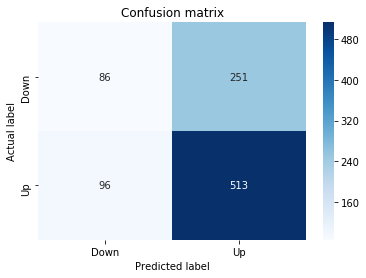

In [198]:
# Make predictions
y_pred_4_lstm=tuned_model_4_lstm.predict(X_test_4_lstm)

# create confustion matrix
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_4, y_pred_4_lstm)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_4, y_pred_4_lstm))
print("Precision:",metrics.precision_score(y_test_4, y_pred_4_lstm))
print("Recall:",metrics.recall_score(y_test_4, y_pred_4_lstm))

### ROC Curve

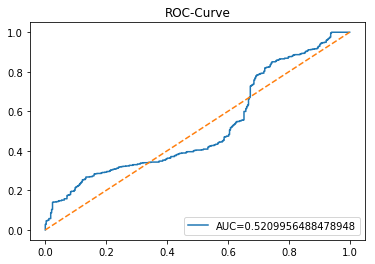

In [199]:
y_proba_4_lstm=tuned_model_4_lstm.predict_proba(X_test_4_lstm)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_4,  y_proba_4_lstm)
auc=metrics.roc_auc_score(y_test_4, y_proba_4_lstm)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

# Model 5: Volatility + Return

## Baseline 

Loss function: log
accuracy of the best model:  0.5551587301587302


Best hyperparameters:
Number of iterations: 10
Penalty: elasticnet
Alpha: 0.0005
l1_ratio: 0.6
Total number of features: 46
Number of selected features: 15


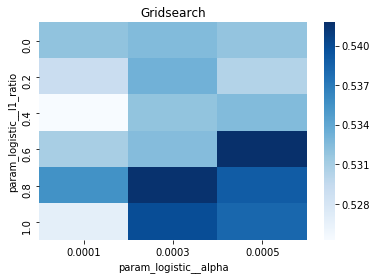

In [478]:
# Model specific Parameter 

# Number of iterations
iterations_5_b=[10] 


# Grid Search

# Regularization  
alpha_g_5_b=[0.0001, 0.0003, 0.0005]
l1_ratio_g_5_b=[0, 0.2, 0.4, 0.6, 0.8, 1] 

# Create hyperparameter options
hyperparameters_g_5_b={'logistic__alpha':alpha_g_5_b, 
                       'logistic__l1_ratio':l1_ratio_g_5_b, 
                       'logistic__penalty':penalty_b,  
                       'logistic__max_iter':iterations_5_b}

# Create grid search 
search_g_5_b=GridSearchCV(estimator=pipeline_b, 
                          param_grid=hyperparameters_g_5_b, 
                          cv=tscv, 
                          verbose=0, 
                          n_jobs=-1, 
                          scoring=scoring_b, 
                          refit=metric_b, 
                          return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated mean Accuracy score. 
# For multiple metric evaluation, this needs to be a string denoting the scorer is used to find the best parameters for refitting the estimator at the end
# If return_train_score=True training results of CV will be saved as well 

# Fit grid search
tuned_model_5_b=search_g_5_b.fit(X_train_5, y_train_5)
#search_g_5_b.cv_results_


# Random Search

# Create regularization hyperparameter distribution using uniform distribution
#alpha_r_5_b=uniform(loc=0.00006, scale=0.002) #loc=0.00006, scale=0.002
#l1_ratio_r_5_b=uniform(loc=0, scale=1) 

# Create hyperparameter options
#hyperparameters_r_5_b={'logistic__alpha':alpha_r_5_b, 'logistic__l1_ratio':l1_ratio_r_5_b, 'logistic__penalty':penalty_b,'logistic__max_iter':iterations_5_b}

# Create randomized search 
#search_r_5_b=RandomizedSearchCV(pipeline_b, hyperparameters_r_5_b, n_iter=10, random_state=1, cv=tscv, verbose=0, n_jobs=-1, scoring=scoring_b, refit=metric_b, return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated Accuracy score.

# Fit randomized search
#tuned_model_5_b=search_r_4_b.fit(X_train_5, y_train_5)



# View Cost function
print('Loss function:', tuned_model_5_b.best_estimator_.get_params()['logistic__loss'])

# View Accuracy 
print(metric_b +' of the best model: ', tuned_model_5_b.best_score_);print("\n")
# best_score_ Mean cross-validated score of the best_estimator

# View best hyperparameters
print("Best hyperparameters:")
print('Number of iterations:', tuned_model_5_b.best_estimator_.get_params()['logistic__max_iter'])
print('Penalty:', tuned_model_5_b.best_estimator_.get_params()['logistic__penalty'])
print('Alpha:', tuned_model_5_b.best_estimator_.get_params()['logistic__alpha'])
print('l1_ratio:', tuned_model_5_b.best_estimator_.get_params()['logistic__l1_ratio'])

# Find the number of nonzero coefficients (selected features)
print("Total number of features:", len(tuned_model_5_b.best_estimator_.steps[1][1].coef_[0][:]))
print("Number of selected features:", np.count_nonzero(tuned_model_5_b.best_estimator_.steps[1][1].coef_[0][:]))

# Gridsearch table
plt.title('Gridsearch')
pvt_5_b=pd.pivot_table(pd.DataFrame(tuned_model_5_b.cv_results_), values='mean_test_accuracy', index='param_logistic__l1_ratio', columns='param_logistic__alpha')
ax_5_b=sns.heatmap(pvt_5_b, cmap="Blues")
plt.show()

### Confusion Matrix

Accuracy: 0.5909090909090909
Precision: 0.629976580796253
Recall: 0.8834154351395731


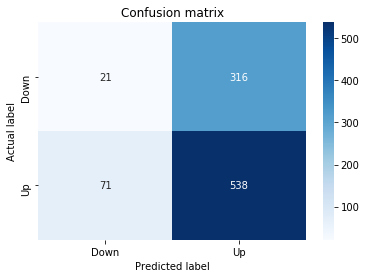

In [479]:
# Make predictions
y_pred_5_b=tuned_model_5_b.predict(X_test_5)

# create confustion matrix
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_5, y_pred_5_b)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_5, y_pred_5_b))
print("Precision:",metrics.precision_score(y_test_5, y_pred_5_b))
print("Recall:",metrics.recall_score(y_test_5, y_pred_5_b))

### ROC Curve

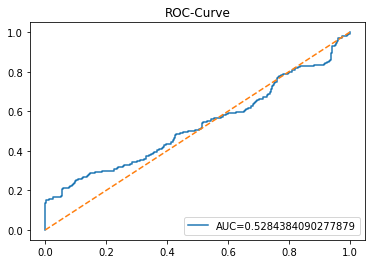

In [480]:
y_proba_5_b=tuned_model_5_b.predict_proba(X_test_5)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_5,  y_proba_5_b)
auc=metrics.roc_auc_score(y_test_5, y_proba_5_b)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

## LSTM

In [389]:
start=time.time()


# number of epochs
epochs=1
# number of units 
LSTM_units_5_lstm=190
# number of samples
num_samples=1 
# time_steps
look_back=1
# numer of features
num_features_5_lstm=X_train_5.shape[1]
# Regularization
dropout_rate=0.
recurrent_dropout=0.3
# print
verbose=0

#hyperparameter
batch_size=[1] 

# hyperparameter
hyperparameter_5_lstm={'batch_size':batch_size}


# create Classifier
clf_5_lstm=KerasClassifier(build_fn=create_shallow_LSTM, 
                           epochs=epochs, 
                           LSTM_units=LSTM_units_5_lstm, 
                           num_samples=num_samples, 
                           look_back=look_back, 
                           num_features=num_features_5_lstm, 
                           dropout_rate=dropout_rate,
                           recurrent_dropout=recurrent_dropout,
                           verbose=verbose)
# Gridsearch
search_5_lstm=GridSearchCV(estimator=clf_5_lstm, 
                           param_grid=hyperparameter_5_lstm,  
                           n_jobs=-1,  
                           cv=tscv, 
                           scoring=scoring_lstm, # accuracy
                           refit=True, 
                           return_train_score=False)

# Fit model
tuned_model_5_lstm=search_5_lstm.fit(X_train_5_lstm, y_train_5, shuffle=False, callbacks=[reset])



print("\n")

# View Accuracy 
print(scoring_lstm +' of the best model: ', tuned_model_5_lstm.best_score_)
# best_score_ Mean cross-validated score of the best_estimator

print("\n")

# View best hyperparameters
print("Best hyperparameters:")
print('epochs:', tuned_model_5_lstm.best_estimator_.get_params()['epochs'])
print('batch_size:', tuned_model_5_lstm.best_estimator_.get_params()['batch_size'])
print('dropout_rate:', tuned_model_5_lstm.best_estimator_.get_params()['dropout_rate'])
print('recurrent_dropout:', tuned_model_5_lstm.best_estimator_.get_params()['recurrent_dropout'])

end=time.time()
print("\n")
print("Running Time:", end - start)



accuracy of the best model:  0.5933862433862434


Best hyperparameters:
epochs: 1
batch_size: 1
dropout_rate: 0.0
recurrent_dropout: 0.3


Running Time: 303.28468012809753


### Confusion Matrix

Accuracy: 0.6596194503171248
Precision: 0.662883087400681
Recall: 0.9589490968801314


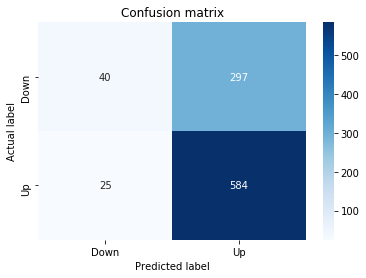

In [390]:
# Make predictions
y_pred_5_lstm=tuned_model_5_lstm.predict(X_test_5_lstm)

# create confustion matrix
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_5, y_pred_5_lstm)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_5, y_pred_5_lstm))
print("Precision:",metrics.precision_score(y_test_5, y_pred_5_lstm))
print("Recall:",metrics.recall_score(y_test_5, y_pred_5_lstm))

### ROC Curce

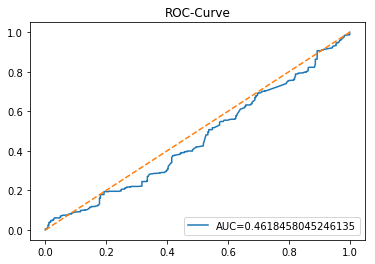

In [393]:
y_proba_5_lstm=tuned_model_5_lstm.predict_proba(X_test_5_lstm)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_5,  y_proba_5_lstm)
auc=metrics.roc_auc_score(y_test_5, y_proba_5_lstm)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

# Model 6: Trading Volume + Return

## Baseline

Loss function: log
accuracy of the best model:  0.5419312169312169


Best hyperparameters:
Number of iterations: 8
Penalty: l1
Alpha: 0.0013
l1_ratio: 0
Total number of features: 46
Number of selected features: 6


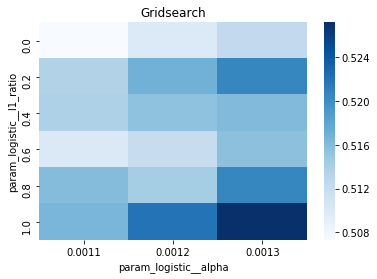

In [53]:
# Model specific Parameter 

# Number of iterations
iterations_6_b=[8] 


# Grid Search

# Regularization  
alpha_g_6_b=[0.0011, 0.0012, 0.0013]
l1_ratio_g_6_b=[0, 0.2, 0.4, 0.6, 0.8, 1] 

# Create hyperparameter options
hyperparameters_g_6_b={'logistic__alpha':alpha_g_6_b, 
                       'logistic__l1_ratio':l1_ratio_g_6_b, 
                       'logistic__penalty':penalty_b,  
                       'logistic__max_iter':iterations_6_b}

# Create grid search 
search_g_6_b=GridSearchCV(estimator=pipeline_b, 
                          param_grid=hyperparameters_g_6_b, 
                          cv=tscv, 
                          verbose=0, 
                          n_jobs=-1, 
                          scoring=scoring_b, 
                          refit=metric_b, 
                          return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated mean Accuracy score. 
# For multiple metric evaluation, this needs to be a string denoting the scorer is used to find the best parameters for refitting the estimator at the end
# If return_train_score=True training results of CV will be saved as well 

# Fit grid search
tuned_model_6_b=search_g_6_b.fit(X_train_6, y_train_6)
#search_g_6_b.cv_results_


# Random Search

# Create regularization hyperparameter distribution using uniform distribution
#alpha_r_6_b=uniform(loc=0.00006, scale=0.002) #loc=0.00006, scale=0.002
#l1_ratio_r_6_b=uniform(loc=0, scale=1) 

# Create hyperparameter options
#hyperparameters_r_6_b={'logistic__alpha':alpha_r_6_b, 'logistic__l1_ratio':l1_ratio_r_6_b, 'logistic__penalty':penalty_b,'logistic__max_iter':iterations_6_b}

# Create randomized search 
#search_r_6_b=RandomizedSearchCV(pipeline_b, hyperparameters_r_6_b, n_iter=10, random_state=1, cv=tscv, verbose=0, n_jobs=-1, scoring=scoring_b, refit=metric_b, return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated Accuracy score.

# Fit randomized search
#tuned_model_6_b=search_r_4_b.fit(X_train_6, y_train_6)



# View Cost function
print('Loss function:', tuned_model_6_b.best_estimator_.get_params()['logistic__loss'])

# View Accuracy 
print(metric_b +' of the best model: ', tuned_model_6_b.best_score_);print("\n")
# best_score_ Mean cross-validated score of the best_estimator

# View best hyperparameters
print("Best hyperparameters:")
print('Number of iterations:', tuned_model_6_b.best_estimator_.get_params()['logistic__max_iter'])
print('Penalty:', tuned_model_6_b.best_estimator_.get_params()['logistic__penalty'])
print('Alpha:', tuned_model_6_b.best_estimator_.get_params()['logistic__alpha'])
print('l1_ratio:', tuned_model_6_b.best_estimator_.get_params()['logistic__l1_ratio'])

# Find the number of nonzero coefficients (selected features)
print("Total number of features:", len(tuned_model_6_b.best_estimator_.steps[1][1].coef_[0][:]))
print("Number of selected features:", np.count_nonzero(tuned_model_6_b.best_estimator_.steps[1][1].coef_[0][:]))

# Gridsearch table
plt.title('Gridsearch')
pvt_6_b=pd.pivot_table(pd.DataFrame(tuned_model_6_b.cv_results_), values='mean_test_accuracy', index='param_logistic__l1_ratio', columns='param_logistic__alpha')
ax_6_b=sns.heatmap(pvt_6_b, cmap="Blues")
plt.show()

### Confusion Matrix

Accuracy: 0.6553911205073996
Precision: 0.6556655665566556
Recall: 0.9786535303776683


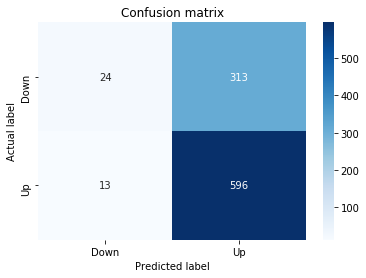

In [54]:
# Make predictions
y_pred_6_b=tuned_model_6_b.predict(X_test_6)

# create confustion matrix
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_6, y_pred_6_b)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_6, y_pred_6_b))
print("Precision:",metrics.precision_score(y_test_6, y_pred_6_b))
print("Recall:",metrics.recall_score(y_test_6, y_pred_6_b))

### ROC Curce

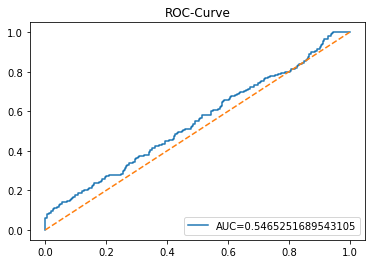

In [55]:
y_proba_6_b=tuned_model_6_b.predict_proba(X_test_6)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_6,  y_proba_6_b)
auc=metrics.roc_auc_score(y_test_6, y_proba_6_b)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

## LSTM

In [301]:
start=time.time()


# number of epochs
epochs=1
# number of units 
LSTM_units_6_lstm=400
# number of samples
num_samples=1 
# time_steps
look_back=1
# numer of features
num_features_6_lstm=X_train_6.shape[1]
# Regularization
dropout_rate=0.
recurrent_dropout=0.5
# print
verbose=0

#hyperparameter
batch_size=[1] 

# hyperparameter
hyperparameter_6_lstm={'batch_size':batch_size}


# create Classifier
clf_6_lstm=KerasClassifier(build_fn=create_shallow_LSTM, 
                           epochs=epochs, 
                           LSTM_units=LSTM_units_6_lstm, 
                           num_samples=num_samples, 
                           look_back=look_back, 
                           num_features=num_features_6_lstm, 
                           dropout_rate=dropout_rate,
                           recurrent_dropout=recurrent_dropout,
                           verbose=verbose)
# Gridsearch
search_6_lstm=GridSearchCV(estimator=clf_6_lstm, 
                           param_grid=hyperparameter_6_lstm,  
                           n_jobs=-1,  
                           cv=tscv, 
                           scoring=scoring_lstm, # accuracy
                           refit=True, 
                           return_train_score=False)

# Fit model
tuned_model_6_lstm=search_6_lstm.fit(X_train_6_lstm, y_train_6, shuffle=False, callbacks=[reset])



print("\n")

# View Accuracy 
print(scoring_lstm +' of the best model: ', tuned_model_6_lstm.best_score_)
# best_score_ Mean cross-validated score of the best_estimator

print("\n")

# View best hyperparameters
print("Best hyperparameters:")
print('epochs:', tuned_model_6_lstm.best_estimator_.get_params()['epochs'])
print('batch_size:', tuned_model_6_lstm.best_estimator_.get_params()['batch_size'])
print('dropout_rate:', tuned_model_6_lstm.best_estimator_.get_params()['dropout_rate'])
print('recurrent_dropout:', tuned_model_6_lstm.best_estimator_.get_params()['recurrent_dropout'])

end=time.time()
print("\n")
print("Running Time:", end - start)



accuracy of the best model:  0.49563492063492065


Best hyperparameters:
epochs: 1
batch_size: 1
dropout_rate: 0.0
recurrent_dropout: 0.5


Running Time: 674.0648419857025


### Confusion Matrix

Accuracy: 0.638477801268499
Precision: 0.6471885336273429
Recall: 0.9638752052545156


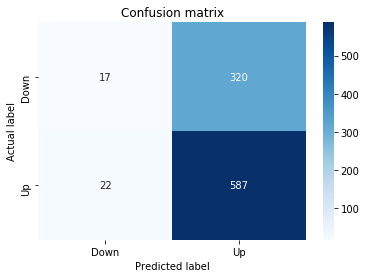

In [302]:
# Make predictions
y_pred_6_lstm=tuned_model_6_lstm.predict(X_test_6_lstm)

# create confustion matrix
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_6, y_pred_6_lstm)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_6, y_pred_6_lstm))
print("Precision:",metrics.precision_score(y_test_6, y_pred_6_lstm))
print("Recall:",metrics.recall_score(y_test_6, y_pred_6_lstm))

### ROC Curve

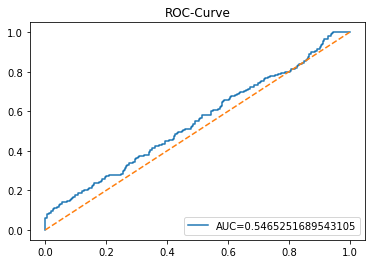

In [303]:
y_proba_6_b=tuned_model_6_b.predict_proba(X_test_6)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_6,  y_proba_6_b)
auc=metrics.roc_auc_score(y_test_6, y_proba_6_b)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

# Model 7: Volatility, Return and Trading Volume 

## Baseline

Loss function: log
accuracy of the best model:  0.5227513227513227


Best hyperparameters:
Number of iterations: 10
Penalty: l1
Alpha: 0.0019
l1_ratio: 0
Total number of features: 69
Number of selected features: 11


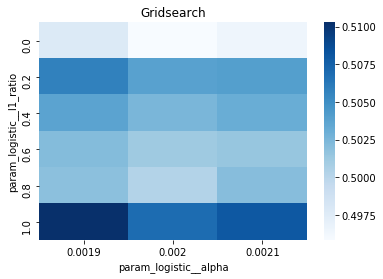

In [295]:
# Model specific Parameter 

# Number of iterations
iterations_7_b=[10] 


# Grid Search

# Regularization  
alpha_g_7_b=[0.0019, 0.002, 0.0021] 
l1_ratio_g_7_b=[0, 0.2, 0.4, 0.6, 0.8, 1] 

# Create hyperparameter options
hyperparameters_g_7_b={'logistic__alpha':alpha_g_7_b, 
                       'logistic__l1_ratio':l1_ratio_g_7_b, 
                       'logistic__penalty':penalty_b,  
                       'logistic__max_iter':iterations_7_b}

# Create grid search 
search_g_7_b=GridSearchCV(estimator=pipeline_b, 
                          param_grid=hyperparameters_g_7_b, 
                          cv=tscv, 
                          verbose=0, 
                          n_jobs=-1, 
                          scoring=scoring_b, 
                          refit=metric_b, 
                          return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated mean Accuracy score. 
# For multiple metric evaluation, this needs to be a string denoting the scorer is used to find the best parameters for refitting the estimator at the end
# If return_train_score=True training results of CV will be saved as well 

# Fit grid search
tuned_model_7_b=search_g_7_b.fit(X_train_7, y_train_7)
#search_g_7_b.cv_results_


# Random Search

# Create regularization hyperparameter distribution using uniform distribution
#alpha_r_7_b=uniform(loc=0.00006, scale=0.002) #loc=0.00006, scale=0.002
#l1_ratio_r_7_b=uniform(loc=0, scale=1) 

# Create hyperparameter options
#hyperparameters_r_7_b={'logistic__alpha':alpha_r_7_b, 'logistic__l1_ratio':l1_ratio_r_7_b, 'logistic__penalty':penalty_b,'logistic__max_iter':iterations_7_b}

# Create randomized search 
#search_r_7_b=RandomizedSearchCV(pipeline_b, hyperparameters_r_7_b, n_iter=10, random_state=1, cv=tscv, verbose=0, n_jobs=-1, scoring=scoring_b, refit=metric_b, return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated Accuracy score.

# Fit randomized search
#tuned_model_7_b=search_r_4_b.fit(X_train_7, y_train_7)



# View Cost function
print('Loss function:', tuned_model_7_b.best_estimator_.get_params()['logistic__loss'])

# View Accuracy 
print(metric_b +' of the best model: ', tuned_model_7_b.best_score_);print("\n")
# best_score_ Mean cross-validated score of the best_estimator

# View best hyperparameters
print("Best hyperparameters:")
print('Number of iterations:', tuned_model_7_b.best_estimator_.get_params()['logistic__max_iter'])
print('Penalty:', tuned_model_7_b.best_estimator_.get_params()['logistic__penalty'])
print('Alpha:', tuned_model_7_b.best_estimator_.get_params()['logistic__alpha'])
print('l1_ratio:', tuned_model_7_b.best_estimator_.get_params()['logistic__l1_ratio'])

# Find the number of nonzero coefficients (selected features)
print("Total number of features:", len(tuned_model_7_b.best_estimator_.steps[1][1].coef_[0][:]))
print("Number of selected features:", np.count_nonzero(tuned_model_7_b.best_estimator_.steps[1][1].coef_[0][:]))

# Gridsearch table
plt.title('Gridsearch')
pvt_7_b=pd.pivot_table(pd.DataFrame(tuned_model_7_b.cv_results_), values='mean_test_accuracy', index='param_logistic__l1_ratio', columns='param_logistic__alpha')
ax_7_b=sns.heatmap(pvt_7_b, cmap="Blues")
plt.show()

### Confusion Matrix

Accuracy: 0.6617336152219874
Precision: 0.656554712892741
Recall: 0.9950738916256158


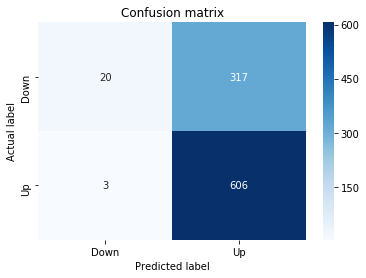

In [296]:
# Make predictions
y_pred_7_b=tuned_model_7_b.predict(X_test_7)

# create confustion matrix
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_7, y_pred_7_b)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_7, y_pred_7_b))
print("Precision:",metrics.precision_score(y_test_7, y_pred_7_b))
print("Recall:",metrics.recall_score(y_test_7, y_pred_7_b))

### ROC Curve

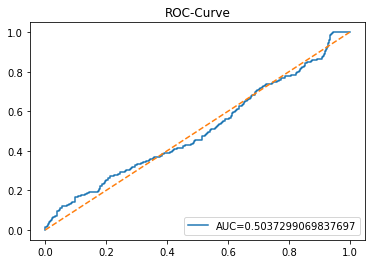

In [297]:
y_proba_7_b=tuned_model_7_b.predict_proba(X_test_7)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_7,  y_proba_7_b)
auc=metrics.roc_auc_score(y_test_7, y_proba_7_b)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

## LSTM

In [244]:
start=time.time()


# number of epochs
epochs=1
# number of units 
LSTM_units_7_lstm=220
# numer of features
num_features_7_lstm=X_train_7.shape[1]
# Regularization
dropout_rate=0.
recurrent_dropout=0.4
# print
verbose=0

#hyperparameter
batch_size=[1] 

# hyperparameter
hyperparameter_7_lstm={'batch_size':batch_size}


# create Classifier
clf_7_lstm=KerasClassifier(build_fn=create_shallow_LSTM, 
                           epochs=epochs, 
                           LSTM_units=LSTM_units_7_lstm, 
                           num_samples=num_samples, 
                           look_back=look_back, 
                           num_features=num_features_7_lstm, 
                           dropout_rate=dropout_rate,
                           recurrent_dropout=recurrent_dropout,
                           verbose=verbose)
# Gridsearch
search_7_lstm=GridSearchCV(estimator=clf_7_lstm, 
                           param_grid=hyperparameter_7_lstm,  
                           n_jobs=-1,  
                           cv=tscv, 
                           scoring=scoring_lstm, # accuracy
                           refit=True, 
                           return_train_score=False)

# Fit model
tuned_model_7_lstm=search_7_lstm.fit(X_train_7_lstm, y_train_7, shuffle=False, callbacks=[reset])



print("\n")

# View Accuracy 
print(scoring_lstm +' of the best model: ', tuned_model_7_lstm.best_score_)
# best_score_ Mean cross-validated score of the best_estimator

print("\n")

# View best hyperparameters
print("Best hyperparameters:")
print('epochs:', tuned_model_7_lstm.best_estimator_.get_params()['epochs'])
print('batch_size:', tuned_model_7_lstm.best_estimator_.get_params()['batch_size'])
print('dropout_rate:', tuned_model_7_lstm.best_estimator_.get_params()['dropout_rate'])
print('recurrent_dropout:', tuned_model_7_lstm.best_estimator_.get_params()['recurrent_dropout'])

end=time.time()
print("\n")
print("Running Time:", end - start)



accuracy of the best model:  0.5313492063492063


Best hyperparameters:
epochs: 1
batch_size: 1
dropout_rate: 0.0
recurrent_dropout: 0.4


Running Time: 288.78774094581604


### Confusion Matrix

Accuracy: 0.6553911205073996
Precision: 0.6539717083786725
Recall: 0.986863711001642


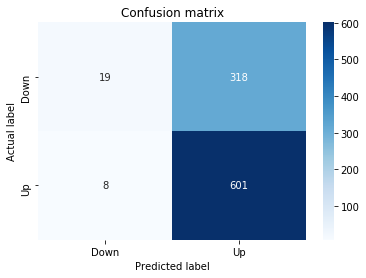

In [245]:
# Make predictions
y_pred_7_lstm=tuned_model_7_lstm.predict(X_test_7_lstm)

# create confustion matrix
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_7, y_pred_7_lstm)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_7, y_pred_7_lstm))
print("Precision:",metrics.precision_score(y_test_7, y_pred_7_lstm))
print("Recall:",metrics.recall_score(y_test_7, y_pred_7_lstm))

### ROC Curve

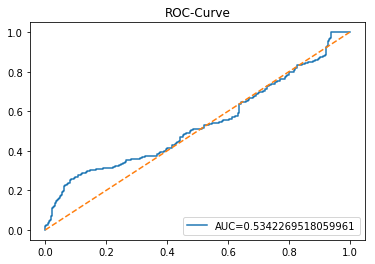

In [247]:
y_proba_7_b=tuned_model_7_b.predict_proba(X_test_7)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_7,  y_proba_7_b)
auc=metrics.roc_auc_score(y_test_7, y_proba_7_b)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()